In [1]:
from __future__ import division, print_function
%matplotlib inline

import matplotlib
import matplotlib.pyplot as plt
matplotlib.style.use('ggplot')
from matplotlib.pyplot import cm
from matplotlib.mlab import PCA as mlabPCA



import pandas as pd
import numpy as np
import tensorflow as tf
from IPython.display import Image, display, clear_output

import sklearn
from tensorflow.python.framework.ops import reset_default_graph

In [2]:
data = pd.read_csv("data.csv", delimiter="\t")
data = data[data["age"] <= 110] # Remove age over 110 years
data = data[data["race"] != 0] # Remove missing race
data = data[data["engnat"] != 0] # Remove missing race
data = data[data["gender"] != 3]
data = data[data["gender"] != 0]
data = data[data["country"] != "(nu"]

data = data.reset_index(True)

data = data.reindex(np.random.permutation(data.index))


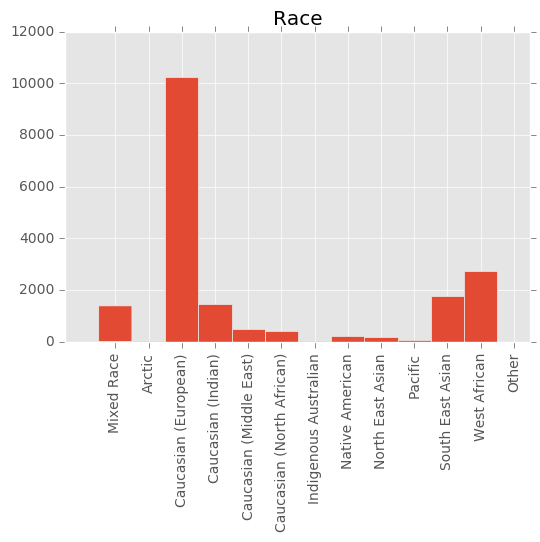

In [3]:
plt.hist(data["race"], bins=12)
plt.title("Race")
race_xticks = ["Mixed Race", "Arctic", "Caucasian (European)",
 "Caucasian (Indian)", "Caucasian (Middle East)",
 "Caucasian (North African)",
 "Indigenous Australian", "Native American",
 "North East Asian", "Pacific",
 "South East Asian",
 "West African", "Other"]
x = [i + 0.5 for i in range(1,14)]
plt.xticks(x,race_xticks,rotation = "vertical")
plt.show()

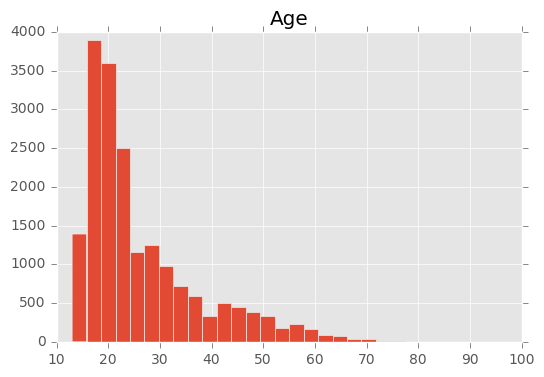

In [4]:
plt.hist(data["age"], bins=30)
plt.title("Age")
plt.show()

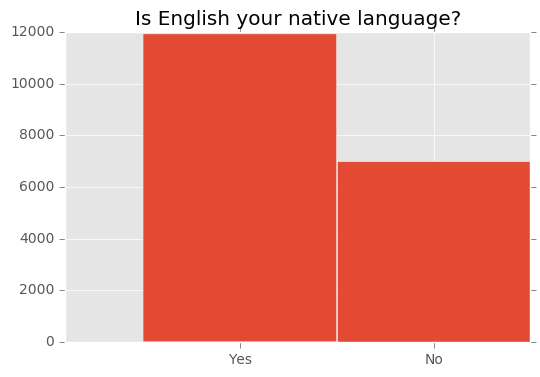

In [5]:
plt.hist(data["engnat"], bins=2)
plt.title("Is English your native language?")

my_xticks = ["Yes", "No"]
x = [1.25,1.75]
plt.xticks(x,my_xticks)
plt.show()

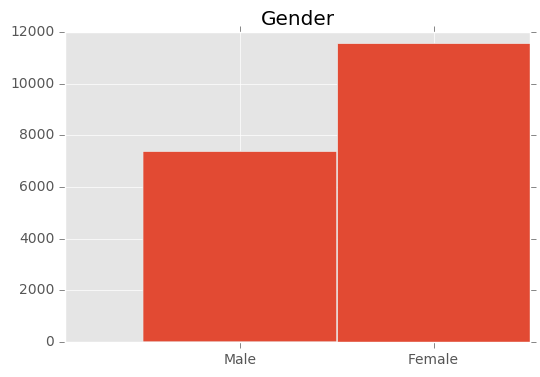

In [6]:
plt.hist(data["gender"], bins=2)
plt.title("Gender")
my_xticks = ["Male", "Female"]
x = [1.25,1.75]
plt.xticks(x,my_xticks)
plt.show()

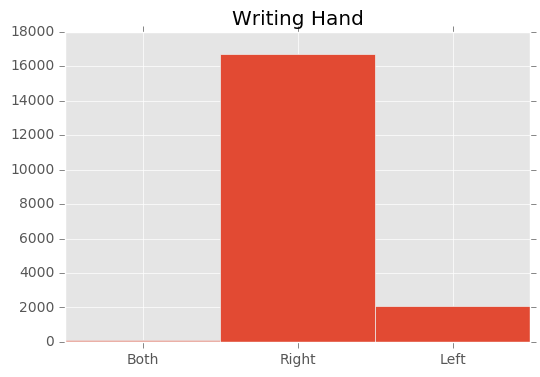

In [7]:
plt.hist(data["hand"], bins=3)
plt.title("Writing Hand")
my_xticks = ["Both", "Right", "Left"]
x = [0.5, 1.5, 2.5]
plt.xticks(x,my_xticks)
plt.show()

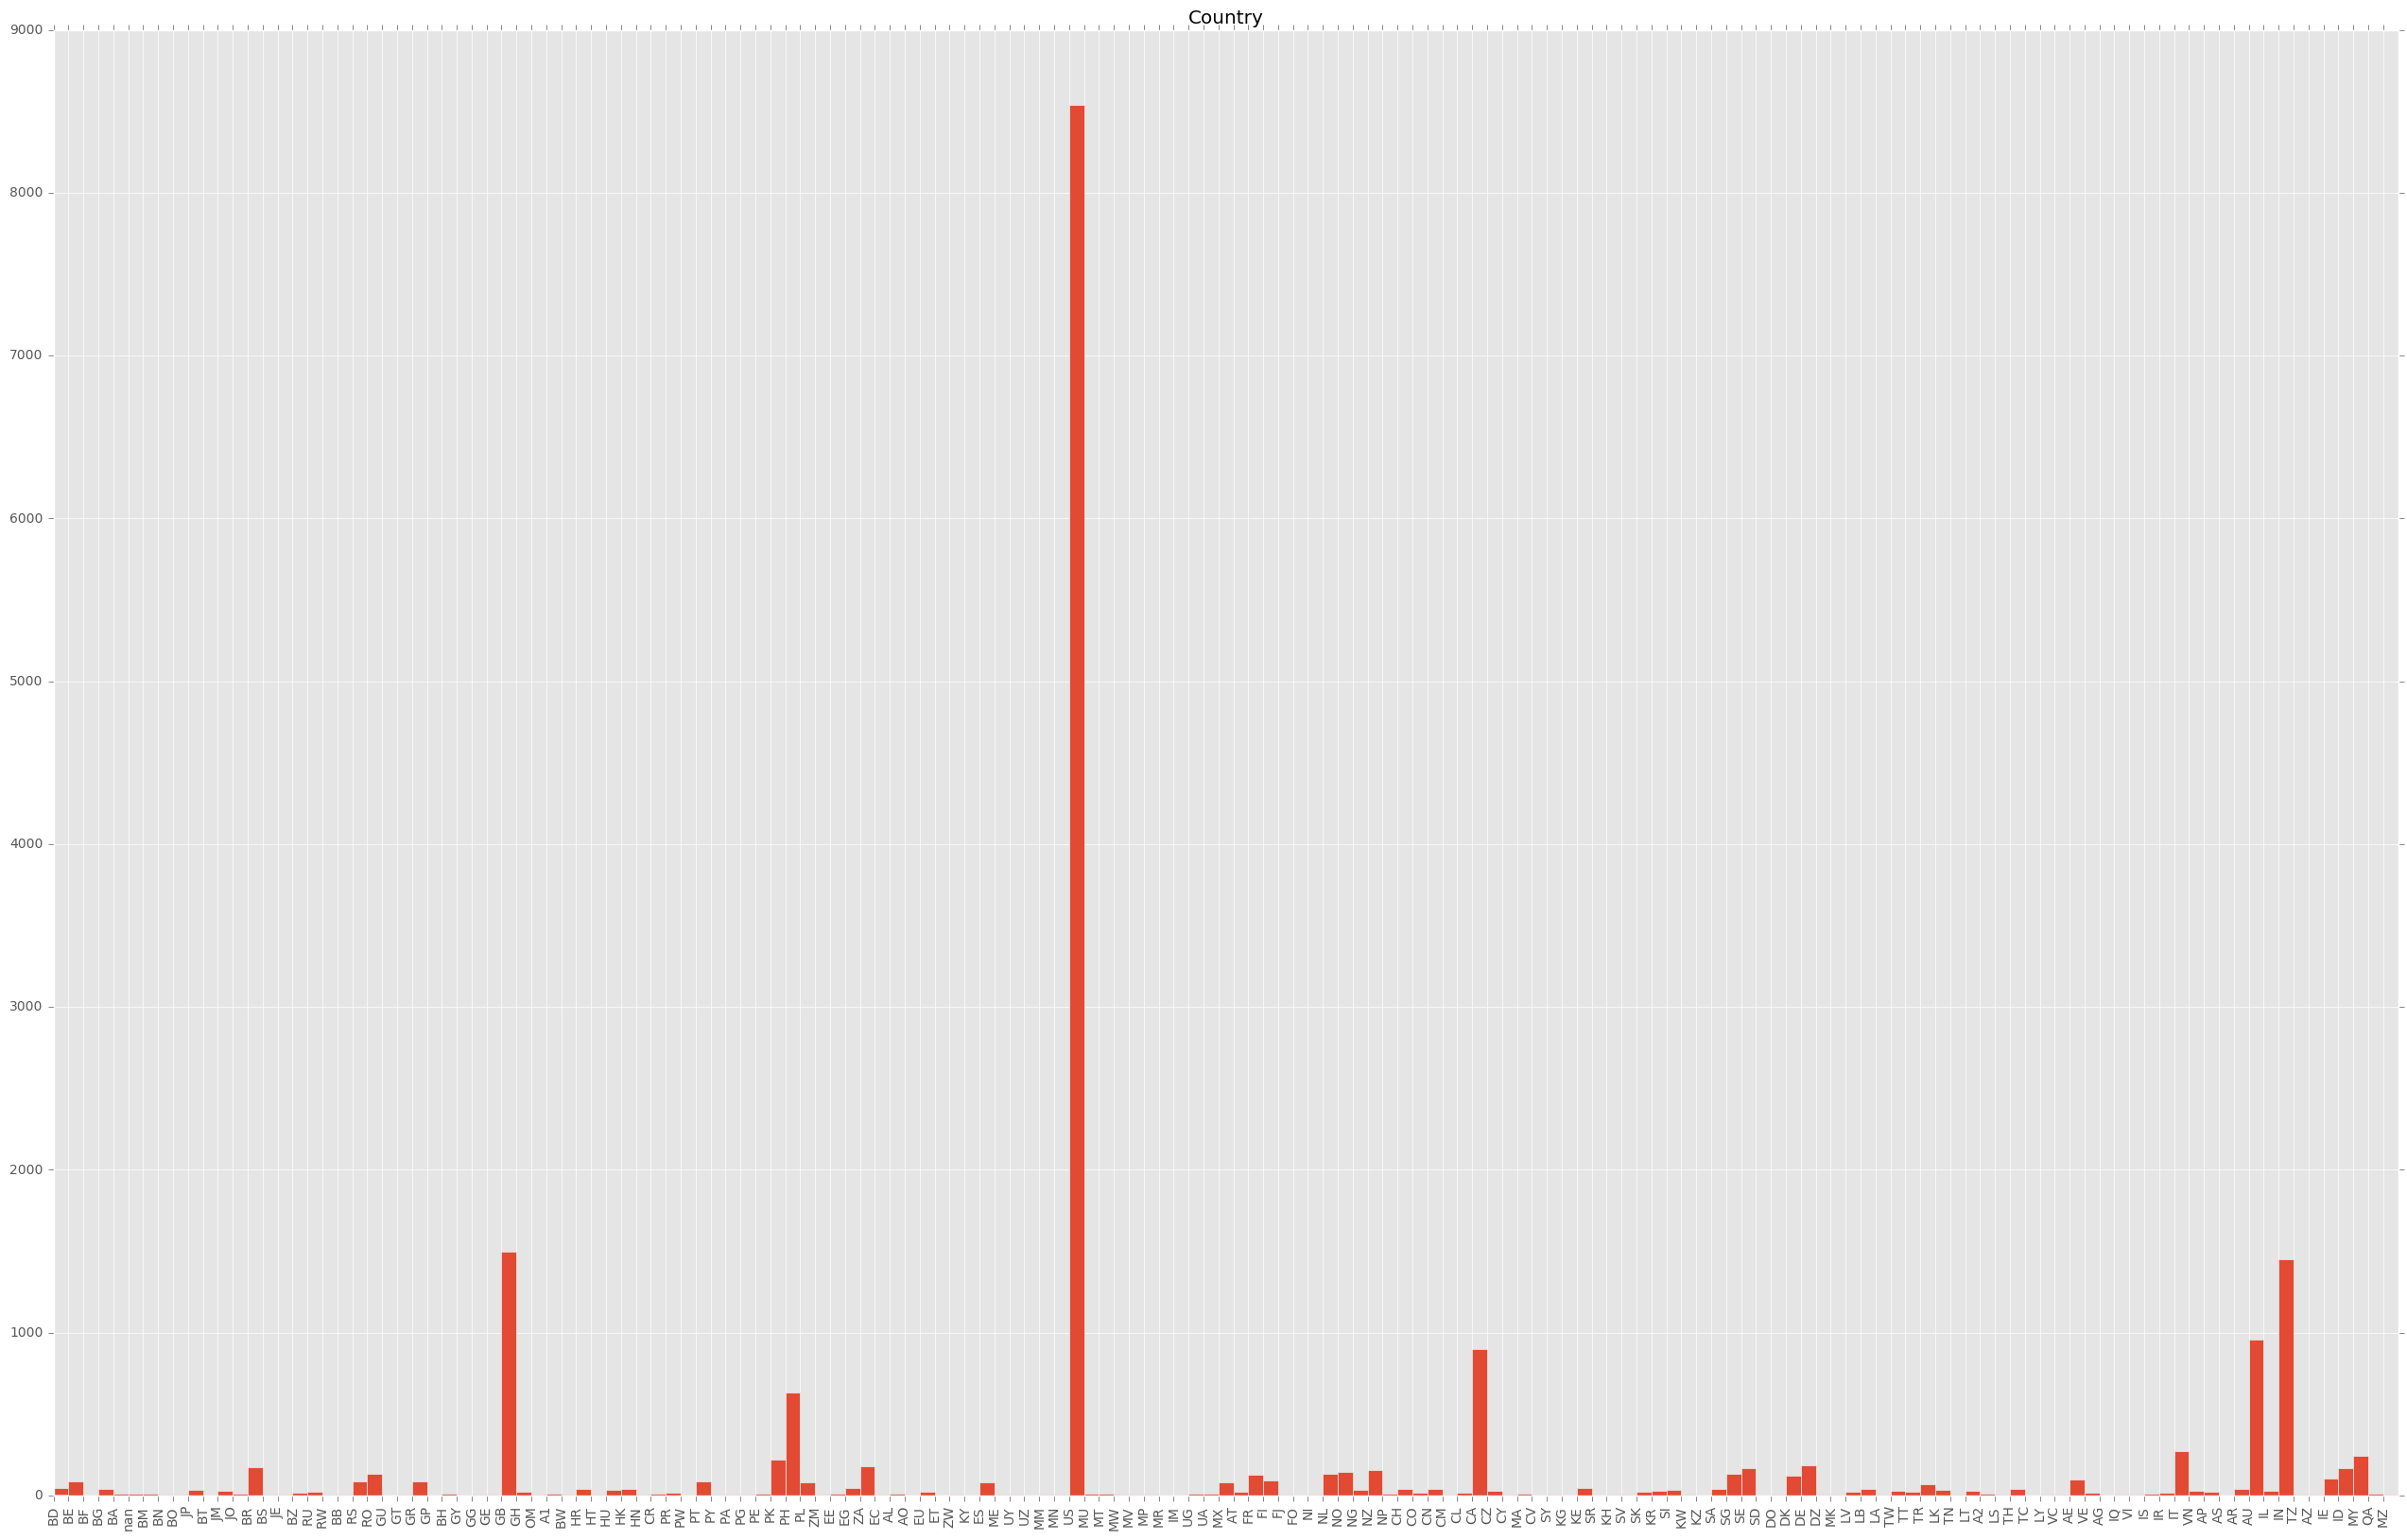

In [8]:
import collections
countrys = collections.Counter(data["country"])

plt.figure(figsize=(32,20))

v = countrys.values()
k = countrys.keys()
plt.xticks(range(len(k)), k, rotation = "vertical")
plt.hist(range(len(k)), weights = v, bins = range(len(k)+1))
plt.title("Country")
plt.show()


In [4]:
def weight_variable(shape):
  initial = tf.truncated_normal(shape, stddev=0.1)
  return tf.Variable(initial)

def bias_variable(shape):
  initial = tf.constant(0.1, shape=shape)
  return tf.Variable(initial)

In [5]:
Q = data.iloc[:,8:]
Q_test = Q[1:10000]
Q_train = Q[10001:15000]
Q_val = Q[15001:]
race_val = data['race'][15001:]

In [6]:
reset_default_graph()

x_pl = tf.placeholder(tf.float32,[None,50])
y_pl = tf.placeholder(tf.float32,[None,50])

n_Q = 50
n_z = 15

n_en = 25
n_de = 25


W_en = weight_variable([n_Q,n_en])
b_en = bias_variable([n_en])
h_en = tf.nn.relu(tf.add(tf.matmul(x_pl, W_en),b_en))


# Variational auto encoder - z
W_z = weight_variable([n_en,n_z])
b_z = bias_variable([n_z])

mean_z = tf.nn.softplus(tf.add(tf.matmul(h_en, W_z), b_z))
#mean_z = (tf.add(tf.matmul(h_en, W_z), b_z))

stddev_z = tf.nn.softmax(tf.add(tf.matmul(h_en, W_z), b_z))

# Gaussian sample
epsilon = tf.random_normal(tf.shape(stddev_z))
z = mean_z# + tf.exp(stddev_z) * epsilon


W_de = weight_variable([n_z,n_de])
b_de = bias_variable([n_de])
h_de = tf.nn.relu(tf.add(tf.matmul(z, W_de),b_de))



# decode
W_out = weight_variable([n_de, n_Q])
b_out = bias_variable([n_Q])

y_hat = tf.nn.softmax(tf.add(tf.matmul(h_de, W_out),b_out))

In [7]:
learning_rate = 0.001

#KL = -(1/2) * tf.reduce_sum(1 + 2 * stddev_z - mean_z**2 -
#                           tf.exp(2 * stddev_z), 1)

# loss for binary class
logist = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels= y_pl, logits = y_hat))

#lower_bound = tf.reduce_mean(logist + KL)

lower_bound = logist

train_step = tf.train.AdamOptimizer(learning_rate).minimize(lower_bound)

In [8]:
sess = tf.Session()
init = tf.global_variables_initializer()
sess.run(init)

In [9]:
def Choose(data,batch_size):
    
    question = np.random.randint(0,data.shape[0],batch_size)
    data_t = np.array(data)
    batch = []
    
    for i in range(batch_size):
        batch += [data_t[question[i]]]
    
    return batch

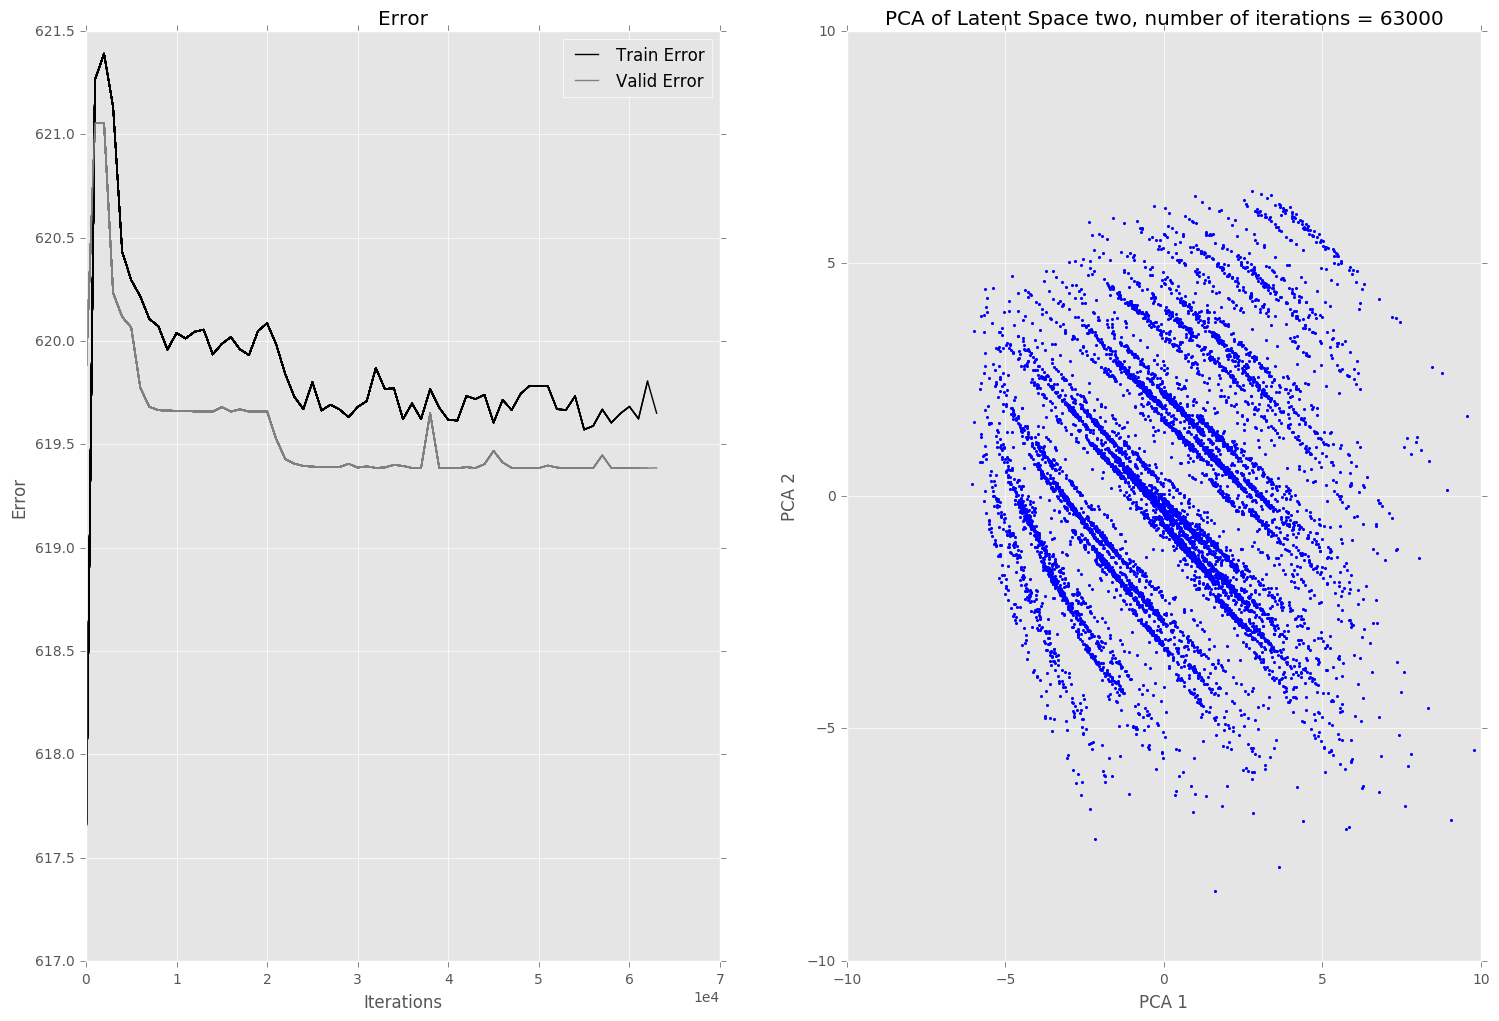

In [10]:
batch_size = 500
# BS = 500, LR 0.0001 = good

num_itre = 100001

LB_train = [] # lower bound value train
cur_train = []
cur_test = [] # lower bound value test
iterations = []
plt.figure(figsize=(18, 12))

try:
    
    for i in range(num_itre):
        
        # training
        Q_xs = Choose(Q_train, batch_size)
        
        res = sess.run([train_step, lower_bound], feed_dict={x_pl: Q_xs, y_pl: Q_xs})
        
        
        _, lower_bound_train = tuple(res)
        
        LB_train += [lower_bound_train]
        
        #==========
        #EVALUATING
        #==========
        
        if((i%1000)==0):
            
            iterations += [i]
            
            res_train = sess.run([lower_bound, z], feed_dict={x_pl: Q_test, y_pl: Q_test})
            
            lower_bound_test, z_eval = tuple(res_train)
            
            # checking for overfit
            # training data
            cur_train += [np.mean(LB_train)]
            LB_train = []
            
            # test data
            cur_test += [np.mean(lower_bound_test)]
            
            #========
            #PLOTTING
            #========
            
            plt.subplot(1,2,1)
            plt.title('Error')
            plt.legend(['Train Error', 'Valid Error'])
            plt.xlabel('Iterations'), plt.ylabel('Error')
            plt.plot(iterations, cur_train, color="black")
            plt.plot(iterations, cur_test, color="grey")
            plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
            plt.grid('on')
            
#            plt.subplot(1,2,2)
#            unique_race = np.unique(race_val)
#            num_race = np.max(unique_race)

#            plt.cla()
#            plt.title('Latent space, number of iterations = %s'%i)
#            color = iter(cm.Set1_r(np.linspace(0,1,num_race)))

#            for j in range(num_race):
#                clr = next(color)
#                plt.scatter(z_eval[race_val == j,0], z_eval[race_val == j,1], c=clr, s=5., lw=0, marker='o', )

#            plt.grid('on')

            
            
            plt.subplot(1,2,2)
            mlab_pca = mlabPCA(z_eval)
            
            plt.cla()
            plt.scatter(mlab_pca.Y[:,0],mlab_pca.Y[:,1], c="blue", s=5., lw=0, marker='o',)
            
            plt.xlabel('PCA 1')
            plt.ylabel('PCA 2')
            plt.xlim([-10,10])
            plt.ylim([-10,10])
            plt.legend()
            plt.title('PCA of Latent Space two, number of iterations = %s'%i)
            
            
            
            plt.savefig("z_space.png")
            display(Image(filename="z_space.png"))
            clear_output(wait=True)
    
except KeyboardInterrupt:
    pass

In [81]:
z_val = np.array(sess.run([mean_z], feed_dict={x_pl: Q_val, y_pl: Q_val}))

unique_race = np.unique(race_val)
num_race = np.max(num_race)

plt.cla()
plt.title('Latent space, number of iterations = %s'%i)
color = iter(cm.Set1_r(np.linspace(0,1,num_race)))

for j in range(num_race):
    clr = next(color)
    plt.scatter(z_val[:,race_val == j,0], z_val[:,race_val == j,1], c=clr, s=5., lw=0, marker='o', )
    
plt.grid('on')


NameError: name 'num_race' is not defined

# Variational Bayes Auto-Encoder

In [ ]:
reset_default_graph()

x_pl = tf.placeholder(tf.float32,[None,50])
y_pl = tf.placeholder(tf.float32,[None,50])

n_Q = 50
n_z = 20

# z
W_z = weight_variable([n_Q,n_z])
b_z = bias_variable([n_z])

mean_z = tf.add(tf.matmul(x_pl, W_z), b_z)

stddev_z = tf.nn.softplus(tf.add(tf.matmul(x_pl, W_z), b_z))

epsilon = tf.random_normal(tf.shape(mean_z))

z = mean_z + tf.exp(stddev_z) * epsilon

# decode
W_out = weight_variable([n_z, n_Q])
b_out = bias_variable([n_Q])

y_hat = tf.nn.softmax(tf.add(tf.matmul(z, W_out),b_out))

learning_rate = 0.004

KL = tf.reduce_sum((1/2) * tf.square(mean_z) + tf.square(stddev_z)
                  - 2 * tf.log(stddev_z + epsilon) - 1)

# loss for binary class
logist = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(labels= y_pl, logits = y_hat))

lower_bound = KL + logist

train_step = tf.train.AdamOptimizer(learning_rate).minimize(lower_bound)

In [ ]:
batch_size = 500
# BS = 500, LR 0.0001 = good

num_itre = 100001

LB_train = [] # lower bound value train
cur_train = []
cur_test = [] # lower bound value test
iterations = []
plt.figure(figsize=(12, 6))

try:
    
    for i in range(num_itre):
        
        # training
        Q_xs = Choose(Q_train, batch_size)
        
        res = sess.run([train_step, lower_bound], feed_dict={x_pl: Q_xs, y_pl: Q_xs})
        
        _, lower_bound_train = tuple(res)
        
        LB_train += [lower_bound_train]
        
        #==========
        #EVALUATING
        #==========
        
        if((i%1000)==0):
            
            iterations += [i]
            
            res_train = sess.run([lower_bound, mean_z], feed_dict={x_pl: Q_test, y_pl: Q_test})
            
            lower_bound_test, z_eval = tuple(res_train)
            
            # checking for overfit
            # training data
            cur_train += [np.mean(LB_train)]
            LB_train = []
            
            # test data
            cur_test += [np.mean(lower_bound_test)]
            
            #========
            #PLOTTING
            #========
            
            plt.subplot(1,2,1)
            plt.title('Error')
            plt.legend(['Train Error', 'Valid Error'])
            plt.xlabel('Iterations'), plt.ylabel('Error')
            plt.plot(iterations, cur_train, color="black")
            plt.plot(iterations, cur_test, color="grey")
            plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
            plt.grid('on')
            
            plt.subplot(1,2,2)
            unique_race = np.unique(race_val)
            num_race = np.max(unique_race)

            plt.cla()
            plt.title('Latent space, number of iterations = %s'%i)
            color = iter(cm.Set1_r(np.linspace(0,1,num_race)))

            for j in range(num_race):
                clr = next(color)
                plt.scatter(z_eval[race_val == j,0], z_eval[race_val == j,1], c=clr, s=5., lw=0, marker='o', )

            plt.grid('on')

            plt.savefig("z_space.png")
            display(Image(filename="z_space.png"))
            clear_output(wait=True)
    
except KeyboardInterrupt:
    pass

## Auto-Encoder

In [ ]:
reset_default_graph()

x_pl = tf.placeholder(tf.float32,[None,50])
y_pl = tf.placeholder(tf.float32,[None,50])

n_Q = 50
n_z = 2

# z
W_z = weight_variable([n_Q,n_z])
b_z = bias_variable([n_z])

z = tf.nn.relu(tf.add(tf.matmul(x_pl, W_z), b_z))

# decode
W_out = weight_variable([n_z, n_Q])
b_out = bias_variable([n_Q])

y_hat = tf.nn.softmax(tf.add(tf.matmul(z, W_out),b_out))

In [ ]:
reset_default_graph()

x_pl = tf.placeholder(tf.float32,[None,50])
y_pl = tf.placeholder(tf.float32,[None,50])

n_Q = 50
n_z = 2

# z
W_z = weight_variable([n_Q,n_z])
b_z = bias_variable([n_z])

z = (tf.add(tf.matmul(x_pl, W_z), b_z))

# decode
W_out = weight_variable([n_z, n_Q])
b_out = bias_variable([n_Q])

y_hat = tf.nn.softmax(tf.add(tf.matmul(z, W_out),b_out))

#learning_rate = 0.0001
learning_rate = 0.0005

# loss for binary class
#logist = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(labels = y_pl, logits = y_hat),axis=1)
logist = tf.reduce_mean(tf.square(y_hat - y_pl))


lower_bound = logist

train_step = tf.train.AdamOptimizer(learning_rate).minimize(lower_bound)

In [ ]:
# One hot version
reset_default_graph()

x_pl = tf.placeholder(tf.int32,[None,50])
x_OH = tf.one_hot(x_pl,5)
y_pl = tf.placeholder(tf.int32,[None,50])
y_OH = tf.one_hot(y_pl,5)

n_Q = 50
n_z = 2

# z
W_z = weight_variable([n_Q, n_Q, n_z, n_z])
b_z = bias_variable([n_z, n_z])


tf.matmul(x_OH, W_z)

#z = tf.nn.relu(tf.add(tf.matmul(x_OH, W_z), b_z))

# decode
#W_out = weight_variable([n_z, n_Q])
#b_out = bias_variable([n_Q])

#y_hat = tf.nn.softmax(tf.add(tf.matmul(z, W_out),b_out))